In [15]:
# Make the requisite imports to my libraries
import requests                                 # Fetch the Doc
from bs4 import BeautifulSoup                   # HTML parser
import pandas as pd                             # Data handling 
import numpy as np                              # Array stuff
import matplotlib.pyplot as plt                 # Visualization
from sklearn.preprocessing import LabelEncoder  # Little flexing of AI/ML muscles
from typing import List, Iterator, Tuple

In [16]:
def fetch_raw_lines(url: str) -> list[str]:
    """Grab a hypothetical Google Doc ⇒ return its visible text lines"""
    resp: requests.Response = requests.get(url)
    resp.raise_for_status()                             # Raise error if its an issue
    soup = BeautifulSoup(resp.text, "html.parser")      # Parse the HTML

    # Retrieve the contents 
    text: str = soup.body.get_text(separator="\n")
    lines: List[str] = [ln.strip() for ln in text.splitlines() if ln.strip()]

    # Drop only the literal header tokens if they appear
    filtered: List[str] = [ln for ln in lines if ln not in ("x", "char", "y")]
    
    return filtered # 

In [17]:
def parse_records(lines: list[str]) -> pd.DataFrame:
    """Zip(group) each line-item into a triple ⇒ convert to 
    appropriate datatypes ⇒ return a DataFrame.
    """

    # Iterator to zip into triples
    it: Iterator[str] = iter(lines)
    triples: Iterator[Tuple[str, str, str]] = zip(it, it, it)

    records: List[dict[str, object]] = []
    for x_str, char, y_str in triples:                  # For each line-item
        if x_str.isdigit() and y_str.isdigit():         # Verification
            records.append({
                "x": int(x_str),
                "char": char,
                "y": int(y_str),
            })

    return pd.DataFrame(records)


In [18]:
def build_grid(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pivot the DataFrame into a 2D grid (rows=y, cols=x) ⇒ fill missing with blank (similar to 1HE),
    ⇒ sort both axes so (0,0) ends up at the top-left ("F"-example).
    """
    grid: pd.DataFrame = (
        df
        .pivot(index="y", columns="x", values="char")                       # Pivot to 2D
        .fillna(" ")
        .sort_index(axis=0, ascending=False)  # Invert Y-vals
        .sort_index(axis=1)                   # Regular X-vals
    )
    return grid

In [19]:
def display_grid(grid: pd.DataFrame):
    """Print the grid as ASCII art in the console ⇒ Render it graphically with matplotlib."""
    arr: np.ndarray = np.array(grid)

    # Console output
    for row in arr:
        print("".join(row.tolist()))

    # Make save-able matplotlib figure
    fig, ax = plt.subplots(
        figsize=(10, 2),
        constrained_layout=True
    )

    # Plot the contents
    for (row_idx, col_idx), ch in np.ndenumerate(arr):  # Iteratin time
        ax.text(
            float(col_idx),
            float(row_idx),
            str(ch),
            family="serif",
            va="top",
            ha="left",
            fontsize=14
        )

    # Pretty it up
    ax.set_xlim(0, 94)
    ax.set_ylim(7, 0)
    ax.set_title("Output of Plot")
    ax.set_axis_on()
    ax.grid(True)

    plt.show()

In [20]:
def reveal_message(doc_url: str):
    """Tying up the steps"""
    lines: List[str] = fetch_raw_lines(doc_url)
    df: pd.DataFrame = parse_records(lines)

    le: LabelEncoder = LabelEncoder()
    df["char_id"] = le.fit_transform(df["char"])

    grid: pd.DataFrame = build_grid(df)
    display_grid(grid)

████████░    ████████░  ██████████░   ███████░ ██░           ███░███░    ███░██░     ██░
██░     ██░███░     ███░██░         ███░    ██░███░   ███░   ██░   ██░  ██░  ██░     ██░
██░     ██░██░       ██░██░        ███░         ██░  █████░ ███░    ██░██░   ██░     ██░
████████░  ██░       ██░████████░  ██░          ███░ ██░██░ ██░      ███░    ██████████░
██░     ██░██░       ██░██░        ███░          ██░██░ ██░██░      ██░██░   ██░     ██░
██░     ██░███░     ███░██░         ███░    ██░  ████░   ████░     ██░  ██░  ██░     ██░
████████░    ████████░  ██████████░   ███████░    ██░     ██░    ███░    ███░██░     ██░


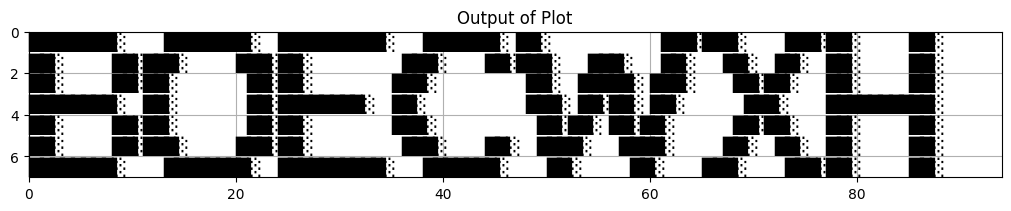

In [21]:
# Example usage:
if __name__ == "__main__":
    URL = "https://docs.google.com/document/d/e/2PACX-1vQGUck9HIFCyezsrBSnmENk5ieJuYwpt7YHYEzeNJkIb9OSDdx-ov2nRNReKQyey-cwJOoEKUhLmN9z/pub"
    reveal_message(URL)